## Monte Carlo simulations of Lennard-Jones fluids

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets

# Load basic science tools
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from numpy.random import rand, randint, uniform, choice, normal 
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [48]:
# Install Plotly and numba for aswesome speed and visualizations
#! pip install plotly
#! pip install numba

import plotly.express as px
from numba import jit, njit

## LJ model of a simple fluids, noble gases


**Check out LJ fluid properties tabulated by NIST for your reference**

https://www.nist.gov/mml/csd/chemical-informatics-research-group/lennard-jones-fluid-properties

In [38]:
#-------Simulation parameters ----
N        = 100      # Try different values
T        = 2.0      # Try different values
rho      = 0.85     # We set density and

### Initializing the system, watch out for clashes!

In [54]:
def initialize_naive(N, rho):
    
    '''Initialize the simulation box 
    given N  particles with density
    returns (N,3) array positions
    '''
    
    L  =  (N/rho)**(1/3) 

    return uniform(-L/2, L/2, size=(N,3))

def initialize(N, rho):
    
    """Put N particles in a box, 
    using dense packing unit lattice size n3"""
    
    L  =  (N/rho)**(1/3) 
    
    n3 = int(N **(1/3))  + 1
    
    iix = iiy = iiz = 0
    pos = np.zeros((N,3))
    
    for i in range(N):
        
        pos[i][0] = (iix + 0.5) * L / n3
        pos[i][1] = (iiy + 0.5) * L / n3
        pos[i][2] = (iiz + 0.5) * L / n3
        
        iix += 1
        
        if iix == n3:
            
            iix  = 0
            iiy += 1
            
            if iiy == n3:
                
                iiy = 0
                iiz += 1 
                
    return pos-L/2

In [55]:
pos = initialize(N, rho)
#px.scatter_3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], opacity=0.5)

In [57]:
initialize(N, rho).shape

(192, 3)

In [56]:
pos.shape

(192, 3)

### Periodic Boundary conditions and minimum image convention

In [41]:
@njit
def pbc_wrap(pp, L):
    
    ''' (a) if pp = (x,y,z) position; wraps it back to box (with origin in the center!) 
        (b) if pp = (dr_x, dr_y, dr_z) distances; uses nearest image convension'''
    
    if pp[0] >  L/2:  pp[0] = pp[0] - L     
    if pp[0] <= -L/2: pp[0] = pp[0] + L
        
    if pp[1] >  L/2:  pp[1] = pp[1] - L     
    if pp[1] <= -L/2: pp[1] = pp[1] + L
    
    if pp[2] >  L/2:  pp[2] = pp[2] - L     
    if pp[2] <= -L/2: pp[2] = pp[2] + L
    
    return pp

### Computing pairwise distances and energies

In [42]:
@njit
def get_r2(p1, p2, L):
    
    ''' Compute squared distance between two particles 
   p1(x,y,z) and p2(x,y,z) while enforcing PBC.'''
    
    p1, p2 = pbc_wrap(p1, L), pbc_wrap(p2, L)  # position wrap back into box
   
    dr     = p2 - p1
    
    dr     = pbc_wrap(dr, L)                   # distance via minimum image 
    
    return dr[0]**2 + dr[1]**2 + dr[2]**2

@njit
def get_e2(pos_i, pos_j, L, sigma=1, eps=1, trunc=3):
    
    pair_e  = 0
    
    dist_sq = get_r2(pos_i, pos_j, L)
                
    if dist_sq <= trunc**2:
                
        pair_e += (sigma/dist_sq)**6 - (sigma/dist_sq)**3
        
    return 4*eps*pair_e

In [43]:
@njit
def getE_tot(particles, L, trunc):
    
    '''Compute Total energy 
    by summing all pairwise interactions'''
    
    N = len(particles)
    energy = 0
    
    for i in range(0, N-1):
        for j in range(i+1, N):
            
                energy += get_e2(particles[i], particles[j], L)
                    
    return energy
    
    
@njit
def getE_one(particles, L, trunc, j, tag_j):
    
    '''Compute energy of a tagged particle j 
    by summing all pairwise interactions with j'''
    
    N = len(particles)
    energy = 0
        
    for i in range(N):
        if i!=j:
                
            energy += get_e2(particles[i], tag_j, L, trunc)
    
    return energy

### MC engine for LJ fluid in 3D (NVT ensemble)
Now that the main helper functions are set up we can put together a main Monte Carlo engine that loops through randomly selected particles and attemps their displacement via Metropolis Criterion. 

In [44]:
@njit
def doMC_LJ(particles, rho, T, trunc=3, steps=10000, freq=1000):

    N      = len(particles)
    L      = (N/rho)**(1/3)
    
    E_tot       = getE_tot(particles, L, trunc) 
    confs, es   = [particles.copy()], [E_tot]
    
    # Loop through MC steps
    
    for step in range(0, steps):
        
        # Randomly choose some particle i in  
        i = randint(N)
    
        #Position and Energy of particle i
        pos_i      = particles[i]
        eng_i      = getE_one(particles, L, trunc, i, pos_i)
    
        #Give particle i a random push delta, from -0.5 to 0.5:
        delta_xyz = rand(3)-0.5 
        
        pos_i_new  = particles[i] + delta_xyz
        eng_i_new  = getE_one(particles, L, trunc, i, pos_i_new)
        
        # Evaluate change in energy
        dE = eng_i_new - eng_i

        # Metropolis acceptance/rejection conditions
        
        if  np.exp(-dE/T) > rand():
            
            particles[i] = pos_i_new
            E_tot       += dE
            
        if step % freq ==0:
            
            confs.append(particles.copy())
            es.append(E_tot)
                    
    return confs, es 

### Running MCMC simulation on LJ system

In [45]:
%run ./code/mc_lj.py

In [46]:
#-------Simulation parameters ----
N        = 100      # Try different values
T        = 0.85     # Try different values
rho      = 1e-3     # We set the density

In [47]:
particles = initialize(N, rho)

%time confs, es = doMC_LJ(particles, rho, T, steps = 1e6,  freq=1000)

CPU times: user 1min 18s, sys: 599 ms, total: 1min 18s
Wall time: 1min 21s


In [287]:
#plt.plot(es[10:])

In [286]:
i = 900
#px.scatter_3d(x=confs[i][:,0], y=confs[i][:,1], z=confs[i][:,2], opacity=0.5)

### Computing Radial Distribution Function $g(r)$

In [318]:
@jit
def get_dists(particles, L):
    '''Compute all pairwise squared distances'''
    
    N   = len(particles)
    r2 = [] 
    
    for i in range(0,N-1):
        for j in range(i+1,N):
            
            r2.append( get_r2(particles[i],particles[j], L) )

    return np.sqrt(r2)

In [324]:
@jit
def comp_g_r(particles, L):
    '''Computing radial distirbution function for a single configuration'''
    
    # Number of particles and density
    N   = len(particles)
    rho = N/(L**3)
    
    #Get dists
    r_dists = get_dists(particles, L)
    
    #Histogram distances 
    histRadii, edges = np.histogram(r_dists, bins=40, range=(0,L/2))
    radii = 0.5 *(edges[1:] + edges[:-1])  
    
    # If we loop over N*N pairs then divide by N 
    # We have N*(N-1)/2 pairs and divide by (N-1)/2 to have hist for N particles
    histRadii = histRadii/(0.5*(N-1))    
    
    #Compute histogram that would be displayed by an ideal gas of N particles 
    vol       = (4.0/3.0) * np.pi * (edges[1:]**3 - edges[:-1]**3)
    
    histIdeal = rho * vol 
    
    gr = histRadii/histIdeal 
    
    return radii, gr

### Simulations for computing $g(r)$

In [320]:
# Simulation for computing g_r
N     = 100
rho   = 0.85
T     = 2 
steps = 2e5
freq  = 200

######
particles       = initialize(N, rho)
%time confs, es = doMC_LJ(particles, L, T, steps, freq)
######

CPU times: user 8.26 s, sys: 83.7 ms, total: 8.34 s
Wall time: 8.7 s


In [321]:
n_pt = int(steps/freq)
n_pt

1000

#### Calculate $g(r)$ over trajectory

In [326]:
gr_t = 0

av_wind = n_pt//2

for i in range(n_pt-av_wind, n_pt):
    
    radii, gr = comp_g_r(confs[i],L)
    
    gr_t += gr/av_wind

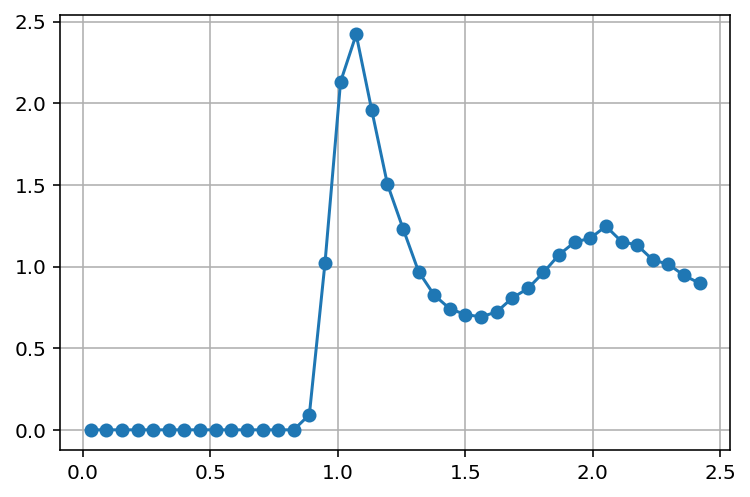

In [327]:
plt.plot(radii, gr_t, '-o')
plt.grid(True)